In [1]:
from pathlib import Path
import json
import tarfile
from collections import Counter

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from entrez_tools.db.assembly import format_summary_meta

In [5]:
%matplotlib inline

## Setup

In [6]:
DATESTR = '211111'
NBNAME = DATESTR + '-inspect-genomes'

In [7]:
# tmpdir = Path('tmp')
# tmpdir.mkdir(exist_ok=True)

processed_out = Path('data-processed') / NBNAME
processed_out.mkdir(exist_ok=True)

In [8]:
infiles = dict(
    esummaries_archive=Path('data-intermediate/211111-find-genomes/assembly-summaries.tar.gz'),
)

In [9]:
outfiles = dict(
    genomes=processed_out / 'genomes.csv',
)

## Load summary data

In [10]:
summaries = dict()

with tarfile.open(infiles['esummaries_archive']) as archive:
    for member in tqdm(archive.getmembers()):
        with archive.extractfile(member) as f:
            summary = json.load(f)
            
        uid = summary['uid']
        assert member.name == uid + '.json'
        
        summary['meta_formatted'] = format_summary_meta(summary['meta'])
        summaries[uid] = summary

100%|██████████| 14388/14388 [00:01<00:00, 7260.47it/s]


In [11]:
nsummaries = len(summaries)
nsummaries

14388

## Inspect schema

In [12]:
key_counts = Counter()
for s in summaries.values():
    key_counts.update(s.keys())
    
assert all(c == nsummaries for c in key_counts.values())
all_keys = sorted(key_counts.keys())

In [13]:
_s = next(iter(summaries.values()))

scalar_keys = sorted(k for k, v in _s.items() if isinstance(v, (str, int, float, bool)))

set(all_keys) - set(scalar_keys)

{'anomalouslist',
 'biosource',
 'busco',
 'exclfromrefseq',
 'gb_bioprojects',
 'gb_projects',
 'meta_formatted',
 'propertylist',
 'rs_bioprojects',
 'rs_projects',
 'synonym'}

In [14]:
meta_key_counts = Counter()
for s in summaries.values():
    meta_key_counts.update(s['meta_formatted'].keys())
    
meta_keys = sorted(meta_key_counts.keys())
meta_keys

['alt_loci_count',
 'assembly-level',
 'assembly-status',
 'chromosome_count',
 'contig_count',
 'contig_l50',
 'contig_n50',
 'non_chromosome_replicon_count',
 'replicon_count',
 'representative-status',
 'scaffold_count',
 'scaffold_count_placed',
 'scaffold_count_unlocalized',
 'scaffold_count_unplaced',
 'scaffold_l50',
 'scaffold_n50',
 'submitter-organization',
 'taxonomy-check-status',
 'total_length',
 'ungapped_length']

In [15]:
for k, c in meta_key_counts.items():
    if c != nsummaries:
        print(k, c)

taxonomy-check-status 14385


In [16]:
_m = next(iter(s['meta_formatted'] for s in summaries.values() if 'taxonomy-check-status' in s['meta_formatted']))

meta_scalar_keys = sorted(k for k in meta_keys if isinstance(_m.get(k), (str, int, float, bool, type(None))))

set(meta_keys) - set(meta_scalar_keys)

set()

## Asserts

In [17]:
for summary in summaries.values():
    assert not summary['exclfromrefseq']
    assert not summary['anomalouslist']
    assert 'latest' in summary['propertylist']

## Make tables

In [18]:
_rows = []

_SUMMARY_KEYS = dict(
    uid='uid',
    refseq_acc='assemblyaccession',
    refseq_category='refseq_category',
    assembly_status='assemblystatus',
    taxid='taxid',
    organism='organism',
    coverage='coverage',
    submission_date='submissiondate',
    last_update_date='lastupdatedate',
)

_META_KEYS = [
    'taxonomy-check-status',
    'assembly-level',
    'total_length',
    'contig_count',
    'scaffold_count',
    'chromosome_count',
    'contig_n50',
    'scaffold_n50',
    'contig_l50',
    'scaffold_l50',
]

for summary in summaries.values():
    _row = {k1: summary[k2] for k1, k2 in _SUMMARY_KEYS.items()}
    _row['propertylist'] = ', '.join(summary['propertylist'])
    
    meta = summary['meta_formatted']
    _row.update({key.replace('-', '_'): meta.get(key) for key in _META_KEYS})
    _row['coverage_num'] = float(_row['coverage'].lstrip('>'))
    
    _rows.append(_row)

genomes_df = pd.DataFrame.from_records(_rows)
genomes_df.set_index('uid', inplace=True)

## Inspect data

### Top-level value counts

In [ ]:
def count_property(name):
    return Counter(s[name] for s in summaries.values())

In [ ]:
for k in scalar_keys:
    counts = count_property(k)
    
    print(f'{k} ({len(counts)})')
    if len(counts) <= 10:
        for v, c in sorted(counts.items(), key=lambda t: t[1], reverse=True):
            print(f'\t{v!r}: {c}')

### Meta value counts

In [ ]:
for k in meta_scalar_keys:
    counts = Counter(summary['meta_formatted'][k] for summary in summaries.values())
    
    print(f'{k} ({len(counts)})')
    if len(counts) <= 10:
        for v, c in sorted(counts.items(), key=lambda t: t[1], reverse=True):
            print(f'\t{v!r}: {c}')

### Property value counts

In [22]:
property_counts = Counter()

for summary in summaries.values():
    property_counts.update(summary['propertylist'])
    
property_counts

Counter({'from-type': 11050,
         'full-genome-representation': 14388,
         'genbank_has_annotation': 11266,
         'has-chromosome': 3753,
         'has_annotation': 14388,
         'latest': 14388,
         'latest_genbank': 14388,
         'latest_refseq': 14384,
         'refseq_has_annotation': 14383,
         'representative': 14388,
         'wgs': 10692,
         'has-plasmid': 1220,
         'reference-guided': 101,
         'partial-genome-representation': 216,
         'has-extrachromosomal-element': 1})

### Assembly status/level

In [23]:
genomes_df.groupby(['assembly_status']).size()

assembly_status
Chromosome          374
Complete Genome    3372
Contig             6175
Scaffold           4467
dtype: int64

In [24]:
genomes_df.groupby(['assembly_level', 'assembly_status']).size()

assembly_level  assembly_status
1               Contig             6175
2               Scaffold           1156
3               Chromosome           55
4               Chromosome          319
6               Scaffold              6
8               Scaffold           3305
90              Complete Genome    3372
dtype: int64

### Taxonomy check status

In [25]:
genomes_df.groupby(['assembly_status', 'taxonomy_check_status'], dropna=False).size()

assembly_status  taxonomy_check_status
Chromosome       Inconclusive               99
                 OK                        275
Complete Genome  Inconclusive              554
                 OK                       2815
                 NaN                         3
Contig           Inconclusive             1150
                 OK                       5025
Scaffold         Inconclusive              736
                 OK                       3731
dtype: int64

### Reference genomes

In [35]:
genomes_df[genomes_df['refseq_category'] == 'reference genome'].sort_values('organism')

,refseq_acc,refseq_category,assembly_status,taxid,organism,coverage,submission_date,last_update_date,propertylist,taxonomy_check_status,assembly_level,total_length,contig_count,scaffold_count,chromosome_count,contig_n50,scaffold_n50,contig_l50,scaffold_l50,coverage_num
uid,,,,,,,,,,,,,,,,,,,,
355058,GCF_000191145.1,reference genome,Complete Genome,871585,Acinetobacter pittii PHEA-2 (g-proteobacteria),0,2011/03/03 00:00,2016/11/29 00:00,"full-genome-representation, genbank_has_annota...",OK,90,3862530,1,1,1,3862530,3862530,1,1,0.0
30588,GCF_000009045.1,reference genome,Complete Genome,224308,Bacillus subtilis subsp. subtilis str. 168 (fi...,0,2009/03/17 00:00,2016/11/29 00:00,"from-type, full-genome-representation, genbank...",OK,90,4215606,1,1,1,4215606,4215606,1,1,0.0
30628,GCF_000009085.1,reference genome,Complete Genome,192222,Campylobacter jejuni subsp. jejuni NCTC 11168 ...,0,2003/05/06 00:00,2016/11/29 00:00,"full-genome-representation, genbank_has_annota...",OK,90,1641481,1,1,1,1641481,1641481,1,1,0.0
42988,GCF_000022005.1,reference genome,Complete Genome,565050,Caulobacter vibrioides NA1000 (a-proteobacteria),0,2009/01/16 00:00,2016/11/29 00:00,"full-genome-representation, genbank_has_annota...",OK,90,4042929,1,1,1,4042929,4042929,1,1,0.0
30308,GCF_000008725.1,reference genome,Complete Genome,272561,Chlamydia trachomatis D/UW-3/CX (chlamydias),0,2001/01/09 00:00,2016/11/29 00:00,"full-genome-representation, genbank_has_annota...",OK,90,1042519,1,1,1,1042519,1042519,1,1,0.0
921311,GCF_000007765.2,reference genome,Complete Genome,227377,Coxiella burnetii RSA 493 (g-proteobacteria),0,2016/11/10 00:00,2017/03/20 00:00,"full-genome-representation, genbank_has_annota...",OK,90,2032807,2,2,1,1995488,1995488,1,1,0.0
1755381,GCF_000008865.2,reference genome,Complete Genome,386585,Escherichia coli O157:H7 str. Sakai (E. coli),0,2018/06/08 00:00,2018/10/04 00:00,"full-genome-representation, genbank_has_annota...",OK,90,5594605,3,3,1,5498578,5498578,1,1,0.0
79781,GCF_000005845.2,reference genome,Complete Genome,511145,Escherichia coli str. K-12 substr. MG1655 (E. ...,0,2013/09/26 00:00,2013/11/06 00:00,"full-genome-representation, genbank_has_annota...",OK,90,4641652,1,1,1,4641652,4641652,1,1,0.0
360158,GCF_000240185.1,reference genome,Complete Genome,1125630,Klebsiella pneumoniae subsp. pneumoniae HS1128...,0,2011/12/27 00:00,2016/11/30 00:00,"full-genome-representation, genbank_has_annota...",OK,90,5682322,7,7,1,5333942,5333942,1,1,0.0


### Refseq accession no?

In [ ]:
no_refseq_acc = [uid for uid, acc in genomes_df['refseq_acc'].items() if not acc.startswith('GCF_')]

In [ ]:
genomes_df.loc[no_refseq_acc]

## Plots

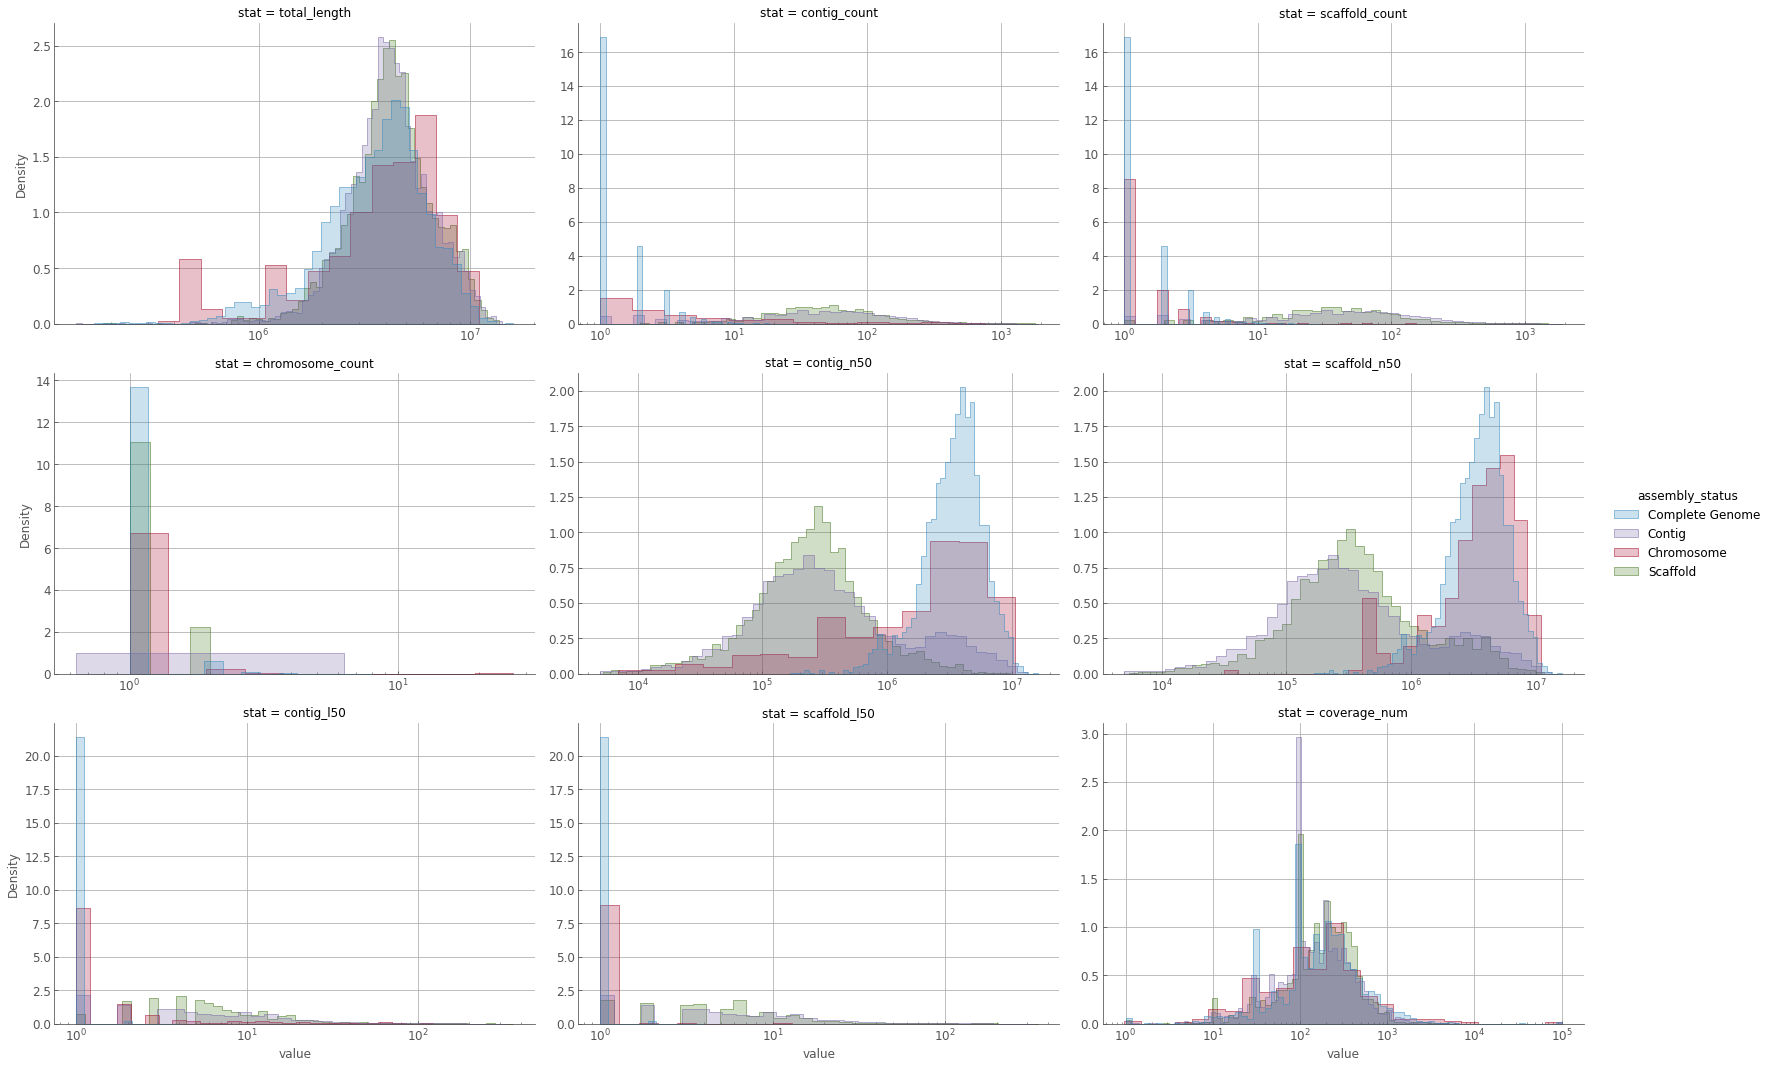

In [28]:
_data = genomes_df.melt(
    id_vars=['assembly_level', 'assembly_status'],
    value_vars=[name for name, dt in genomes_df.dtypes.iteritems() if dt.kind != 'O'],
    var_name='stat',
)

sns.displot(
    data=_data[_data['value'] > 0],
    kind='hist',
    x='value',
    col='stat',
    hue='assembly_status',
    element='step',
    stat='density',
    col_wrap=3,
    aspect=1.5,
    log_scale=True,
    common_bins=False,
    common_norm=False,
    facet_kws=dict(sharex=False, sharey=False),
)

<AxesSubplot:xlabel='total_length', ylabel='Count'>

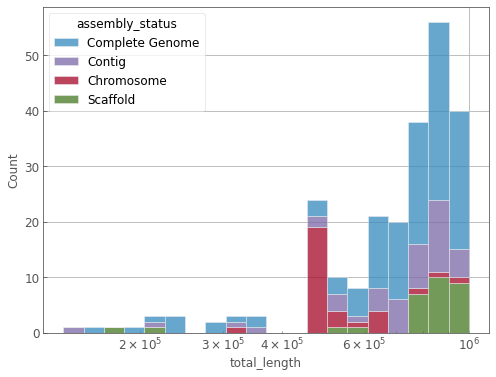

In [29]:
sns.histplot(
    data=genomes_df,
    x='total_length',
    hue='assembly_status',
    multiple='stack',
    bins=20,
    binrange=(np.log10(genomes_df.total_length.min()), 6),
    log_scale=True,
)

<AxesSubplot:xlabel='coverage_num', ylabel='Count'>

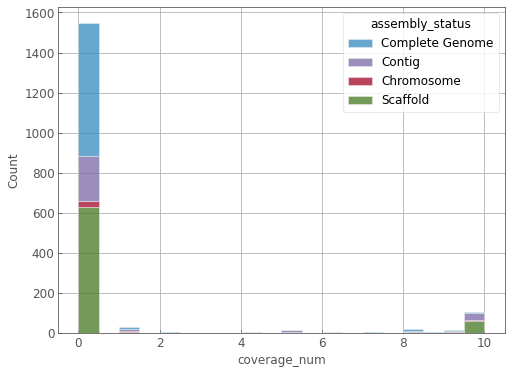

In [30]:
sns.histplot(
    data=genomes_df,
    x='coverage_num',
    hue='assembly_status',
    multiple='stack',
    bins=20,
    binrange=(genomes_df.coverage_num.min(), 10),
    # log_scale=True,
)

In [31]:
issmall = genomes_df['total_length'] < 5e5
print(issmall.sum())
genomes_df[issmall].sort_values('total_length')

42


,refseq_acc,refseq_category,assembly_status,taxid,organism,coverage,submission_date,last_update_date,propertylist,taxonomy_check_status,assembly_level,total_length,contig_count,scaffold_count,chromosome_count,contig_n50,scaffold_n50,contig_l50,scaffold_l50,coverage_num
uid,,,,,,,,,,,,,,,,,,,,
773561,GCF_900080145.1,representative genome,Contig,189385,Candidatus Tremblaya princeps (b-proteobacteria),592,2016/07/16 00:00,2019/09/01 00:00,"full-genome-representation, genbank_has_annota...",Inconclusive,1,137475,4,4,0,75297,75297,1,1,592.0
421728,GCF_000287275.1,representative genome,Complete Genome,1202538,Candidatus Carsonella ruddii HC isolate Thao20...,0,2012/08/13 00:00,2021/04/28 00:00,"full-genome-representation, genbank_has_annota...",Inconclusive,90,166163,1,1,1,166163,166163,1,1,0.0
1520181,GCF_900241015.1,representative genome,Scaffold,1870999,Metaprevotella massiliensis (CFB group bacteria),155,2018/01/02 00:00,2018/01/17 00:00,"from-type, full-genome-representation, has_ann...",OK,2,185014,23,16,0,21675,93329,3,1,155.0
2318151,GCF_004296495.1,representative genome,Complete Genome,1972133,endosymbiont of Rhynchophorus ferrugineus (g-p...,17,2017/10/21 00:00,2019/09/01 00:00,"full-genome-representation, genbank_has_annota...",Inconclusive,90,200316,1,1,1,200316,200316,1,1,17.0
6232951,GCF_011319365.1,representative genome,Scaffold,2607407,Rhizobium flavescens (a-proteobacteria),100,2020/03/16 00:00,2020/03/22 00:00,"from-type, full-genome-representation, has-pla...",OK,2,209611,13,13,0,23095,23095,3,3,100.0
2318171,GCF_004296535.1,representative genome,Complete Genome,650377,endosymbiont of Euscepes postfasciatus (g-prot...,116,2017/10/21 00:00,2019/02/27 00:00,"full-genome-representation, genbank_has_annota...",Inconclusive,90,219841,1,1,1,219841,219841,1,1,116.0
11176851,GCF_009805595.3,representative genome,Contig,1010676,Candidatus Tremblaya phenacola (b-proteobacteria),10,2021/10/13 00:00,2021/10/15 00:00,"full-genome-representation, genbank_has_annota...",Inconclusive,1,221077,7,7,0,63038,63038,2,2,10.0
2318161,GCF_004296515.1,representative genome,Complete Genome,1971488,endosymbiont of Pachyrhynchus infernalis (g-pr...,380,2017/10/21 00:00,2019/02/27 00:00,"full-genome-representation, genbank_has_annota...",Inconclusive,90,226299,1,1,1,226299,226299,1,1,380.0
2318141,GCF_004296475.1,representative genome,Complete Genome,1972134,endosymbiont of Sipalinus gigas (g-proteobacte...,17,2017/10/21 00:00,2019/02/27 00:00,"full-genome-representation, genbank_has_annota...",Inconclusive,90,232663,2,2,1,230546,230546,1,1,17.0


## Write output

In [32]:
genomes_df.to_csv(outfiles['genomes'])